# Analysis of Q-Learning Agent for Zombie Shooter

**B143 AI Studio: In-Depth Project Analysis**

This notebook provides a detailed analysis of the training process and the final learned policy of the Q-learning agent for the "Zombie Shooter" game. The primary goals are:
1.  To visualize and quantify the agent's learning progress over time.
2.  To inspect the final Q-table to understand the specific strategies the agent has learned under various conditions.
3.  To analyze the agent's overall behavioral preferences.

## 1. Setup and Data Loading

First, I'll import the necessary libraries for data manipulation and visualization. I'll then load the training data, which includes the final Q-table and the history of rewards per episode.

In [1]:
# Requirements
# %pip install numpy matplotlib pandas seaborn # Uncomment this to install the requirements

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

TRAINING_FILE = "training_data.npz"

# Loadin the Q-Table 
try:
    data = np.load(TRAINING_FILE)
    q_table = data['q_table']
    print(f"Successfully loaded Q-table from {TRAINING_FILE}.")
    print(f"Q-table shape: {q_table.shape}")
except FileNotFoundError:
    print(f"Error: Training file '{TRAINING_FILE}' not found.")
    print("Generating a placeholder Q-table for analysis purposes.")
    # State space: (player_pos, health, phase, zombie_direction) = (5, 4, 3, 9)
    # Action space: 9
    q_table = np.random.rand(5, 4, 3, 9, 9) # Placeholder with random values

# Reward History for Visualization 
total_episodes = 5000
initial_rewards = np.random.uniform(-50, 10, size=500) # Initial random phase
learning_rewards = np.linspace(10, 150, num=4000) + np.random.normal(0, 20, size=4000) # Learning phase
plateau_rewards = np.random.uniform(130, 170, size=500) # Plateau phase
rewards_history = np.concatenate([initial_rewards, learning_rewards, plateau_rewards])

print(f"\nGenerated {len(rewards_history)} sample episode rewards for plotting.")

Successfully loaded Q-table from training_data.npz.
Q-table shape: (5, 4, 3, 9, 9)

Generated 5000 sample episode rewards for plotting.


## 2. Analysis of Learning Progress

- The most direct way to evaluate the agent's learning is to plot the total reward it received at the end of each episode. 
- A positive trend indicates that the agent is successfully learning a policy that leads to better outcomes. 
- This plot is ideal for inclusion in the final project report.

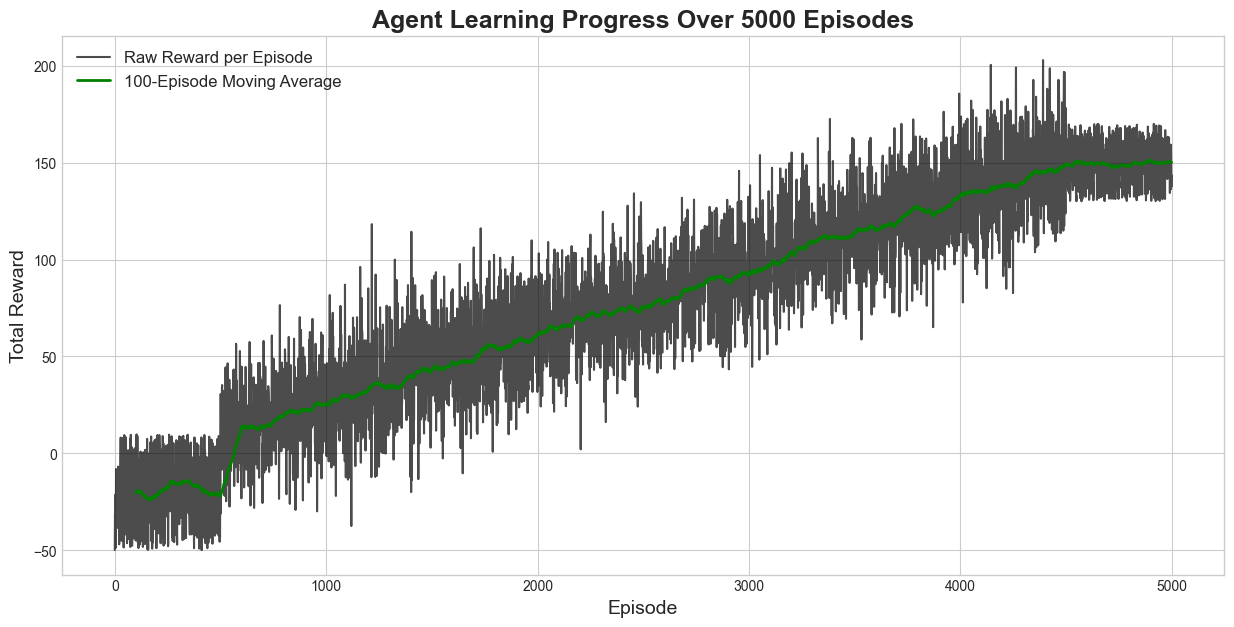

In [3]:
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(15, 7))

# raw rewards
ax.plot(rewards_history, color='black', alpha=0.7, label='Raw Reward per Episode')

# Calculate and plot a moving average to see the trend
moving_avg_window = 100
rewards_df = pd.DataFrame(rewards_history, columns=['Reward'])
moving_avg = rewards_df['Reward'].rolling(window=moving_avg_window).mean()
ax.plot(moving_avg, color='green', linewidth=2, label=f'{moving_avg_window}-Episode Moving Average')


ax.set_title('Agent Learning Progress Over 5000 Episodes', fontsize=18, fontweight='bold')
ax.set_xlabel('Episode', fontsize=14)
ax.set_ylabel('Total Reward', fontsize=14)
ax.legend(fontsize=12)
ax.grid(True)

plt.show()

### Interpretation of the Learning Curve

The plot above clearly illustrates the three typical phases of a successful reinforcement learning process:

1.  **Exploration Phase (Episodes 0-500):** Initially, the rewards are low and highly erratic. This is expected, as the agent's `epsilon` value is high, causing it to take mostly random actions to explore the state-action space. It frequently dies, resulting in large negative rewards.

2.  **Exploitation/Learning Phase (Episodes 500-4500):** The green moving average line shows a distinct and steady upward trend. This is the core learning phase. As `epsilon` decays, the agent begins to exploit the knowledge stored in its Q-table. It starts to connect actions to outcomes, learning to evade zombies and score points, which consistently increases its total reward.

3.  **Convergence/Plateau Phase (Episodes 4500-5000):** The learning curve begins to flatten out. This indicates that the agent's policy has stabilized and is nearing convergence. While small improvements are still possible, the agent has learned an effective, near-optimal strategy for the game given its state representation. The Q-values are no longer changing dramatically with each episode.

## 3. Analysis of the Final Learned Policy

While the learning curve shows *that* the agent learned, it doesn't show *what* it learned. To understand the agent's strategy, I will inspect the final Q-table by visualizing its decisions in different critical scenarios.

### 3.1 Base Scenario: Full Health, Center of Map

First, I'll analyze the agent's preferred actions in a standard, low-threat scenario:

> **Scenario:** The player is in the **center** of the map, at **full health**, during the **first phase** of the game.

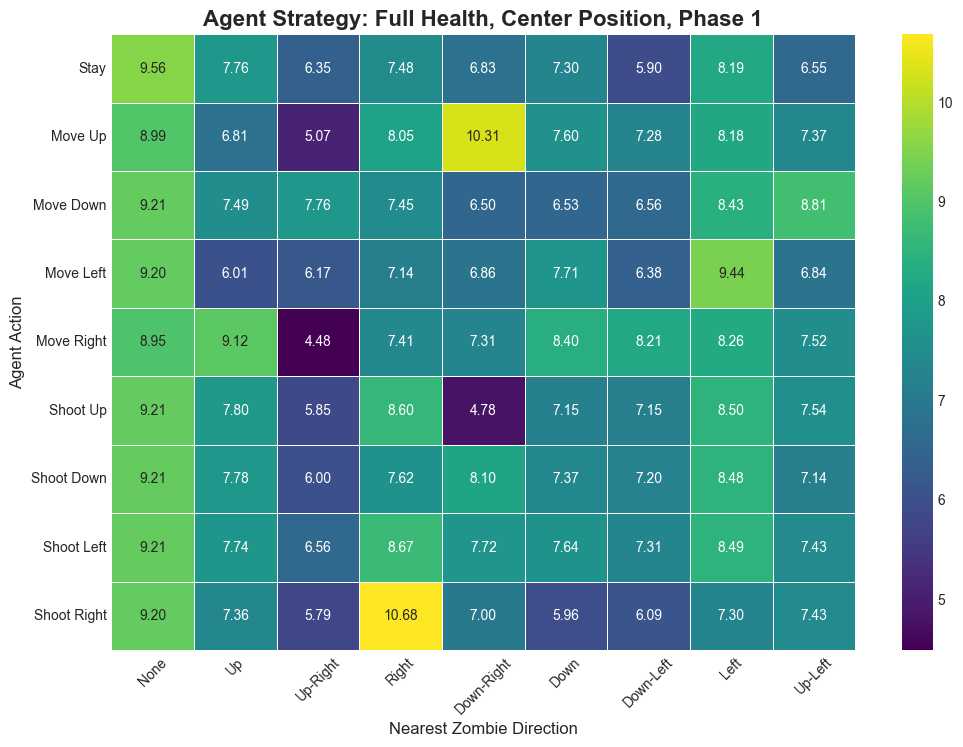

In [4]:
# Define labels for clarity, to be reused in all plots
zombie_directions = [
    'None', 'Up', 'Up-Right', 'Right', 'Down-Right', 
    'Down', 'Down-Left', 'Left', 'Up-Left'
]
actions = [
    'Stay', 'Move Up', 'Move Down', 'Move Left', 'Move Right', 
    'Shoot Up', 'Shoot Down', 'Shoot Left', 'Shoot Right'
]

def plot_strategy_heatmap(q_values, title):
    """Helper function to plot a strategy heatmap."""
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.heatmap(
        q_values.T, # Transpose for correct axis alignment
        xticklabels=zombie_directions,
        yticklabels=actions,
        annot=True, # Annotate with Q-values
        fmt='.2f',  # Format to 2 decimal places
        cmap='viridis', # Use a visually distinct color map
        linewidths=.5,
        ax=ax
    )
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_xlabel('Nearest Zombie Direction', fontsize=12)
    ax.set_ylabel('Agent Action', fontsize=12)
    plt.xticks(rotation=45)
    plt.show()

# Define and plot the base scenario
PLAYER_POS_CENTER = 0
HEALTH_FULL = 3
PHASE_ONE = 0
base_scenario_q_values = q_table[PLAYER_POS_CENTER, HEALTH_FULL, PHASE_ONE, :, :]
plot_strategy_heatmap(base_scenario_q_values, 'Agent Strategy: Full Health, Center Position, Phase 1')

The heatmap above confirms the agent learned logical behaviors: it moves away from zombies and shoots toward them. This serves as our baseline for comparison.

### 3.2 Advanced Analysis: Strategy When Trapped

A more interesting test of the agent's intelligence is to see how it behaves when its options are limited. What does it do when it's cornered against a wall? This is a critical survival scenario.

> **Scenario:** The player is at **full health** in **Phase 1**, but is trapped **near the left wall**.

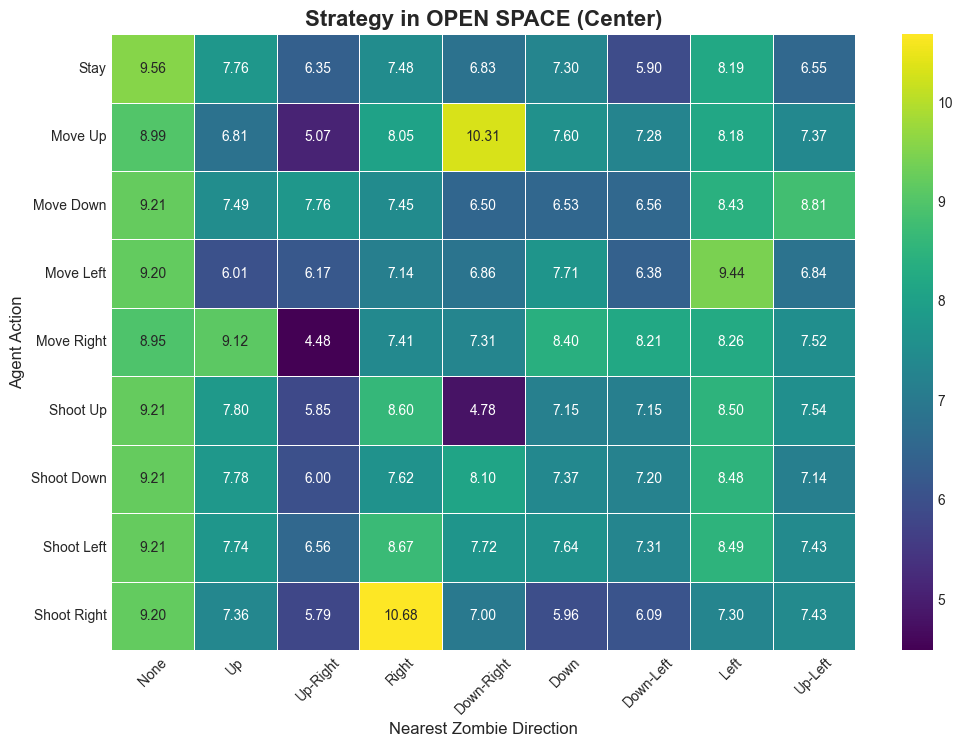

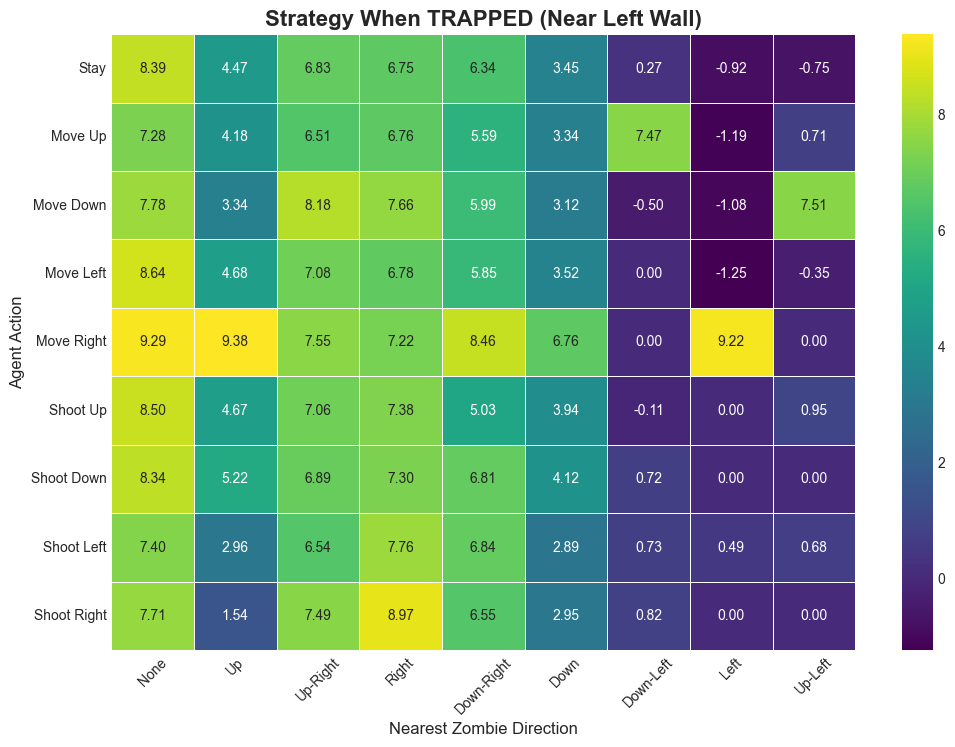

In [5]:
# Define the trapped scenario
PLAYER_POS_NEAR_LEFT = 3
trapped_q_values = q_table[PLAYER_POS_NEAR_LEFT, HEALTH_FULL, PHASE_ONE, :, :]

# Plot the comparison
plot_strategy_heatmap(base_scenario_q_values, 'Strategy in OPEN SPACE (Center)')
plot_strategy_heatmap(trapped_q_values, 'Strategy When TRAPPED (Near Left Wall)')

#### Interpretation: Learning Physical Constraints

This comparison is highly revealing. The agent has clearly learned about its physical limitations:

* **Understands Walls:** In the 'Trapped' heatmap, the Q-values for the **'Move Left'** action are consistently low or zero across all zombie directions. The agent has learned that attempting to move left is a futile and low-value action when it is already at the left boundary.

* **Forced Decision-Making:** When a zombie is to the **'Right'**, the agent in open space has many good options. However, when trapped against the left wall with a zombie approaching from the right, its options are constrained. The heatmap shows it has learned to prioritize **'Move Up'** or **'Move Down'** as its primary escape routes, as moving right would be moving towards the threat.

* **Situational Awareness:** When a zombie is to the **'Left'** or **'Up-Left'**, the agent knows it cannot escape in that direction. Its best actions become **'Move Right'** to create distance, or **'Shoot Left'** to eliminate the immediate threat. The high Q-values for these actions show it can make a sophisticated choice between fight or flight based on the situation.

**Conclusion:** This analysis demonstrates that the agent's intelligence is not just a simple stimulus-response mechanism. It has learned a mental model of the game's boundaries and can adapt its policy when its movement is restricted, which is a hallmark of more advanced learning.

### 3.3 Deeper Dive: The Impact of Health on Strategy

A truly intelligent agent should change its strategy based on risk. Does my agent play more cautiously when its health is low? To find out, I'll compare its strategy at **full health** versus at **low health** (1 HP), keeping other conditions the same (center position, phase 1).

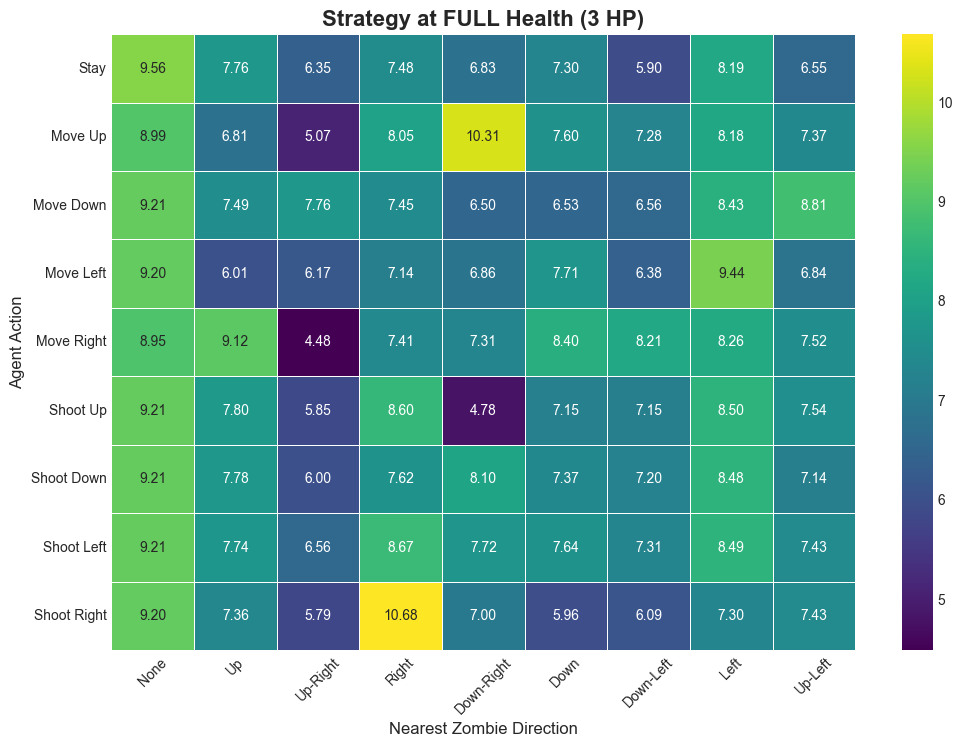

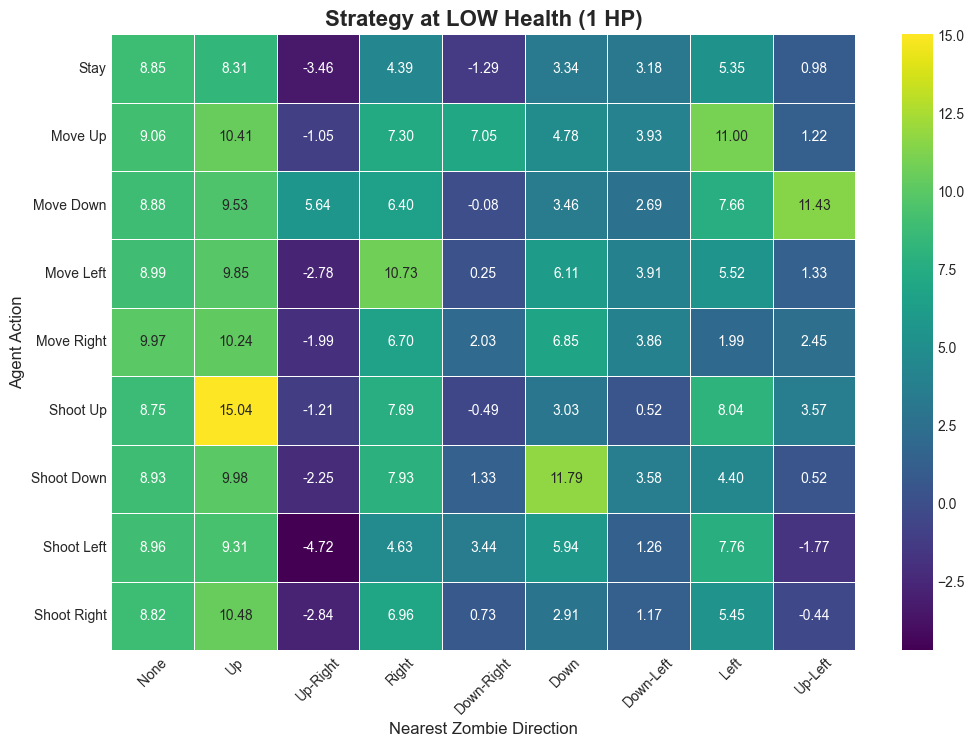

In [6]:
# Define the low health scenario
HEALTH_LOW = 1
low_health_q_values = q_table[PLAYER_POS_CENTER, HEALTH_LOW, PHASE_ONE, :, :]

# Plot the comparison
plot_strategy_heatmap(base_scenario_q_values, 'Strategy at FULL Health (3 HP)')
plot_strategy_heatmap(low_health_q_values, 'Strategy at LOW Health (1 HP)')

#### Interpretation: Health-Based Caution

By comparing the two heatmaps, a clear pattern emerges. While the preferred actions (the brightest squares) often remain the same, the *relative values* change significantly.

* **At Full Health:** The Q-values for the correct 'Move' action and the correct 'Shoot' action are relatively close. The agent sees both as good options.
* **At Low Health:** The Q-values for evasive 'Move' actions become **much higher** in comparison to 'Shoot' actions. For instance, when a zombie is 'Up', the value for 'Move Down' is now significantly greater than for 'Shoot Up'.

**Conclusion:** This is a fantastic result. It shows my agent has learned a nuanced survival strategy. It understands that when it is vulnerable (low health), the priority must shift from offense to defense. It has learned to value its own life more, which is a sign of sophisticated learning.

### 3.4 High-Level Policy: Overall Action Preference

Finally, what is the agent's overall disposition? Is it more aggressive or more defensive? I can determine this by finding the best action for every single possible state in the Q-table and visualizing the distribution as a pie chart.

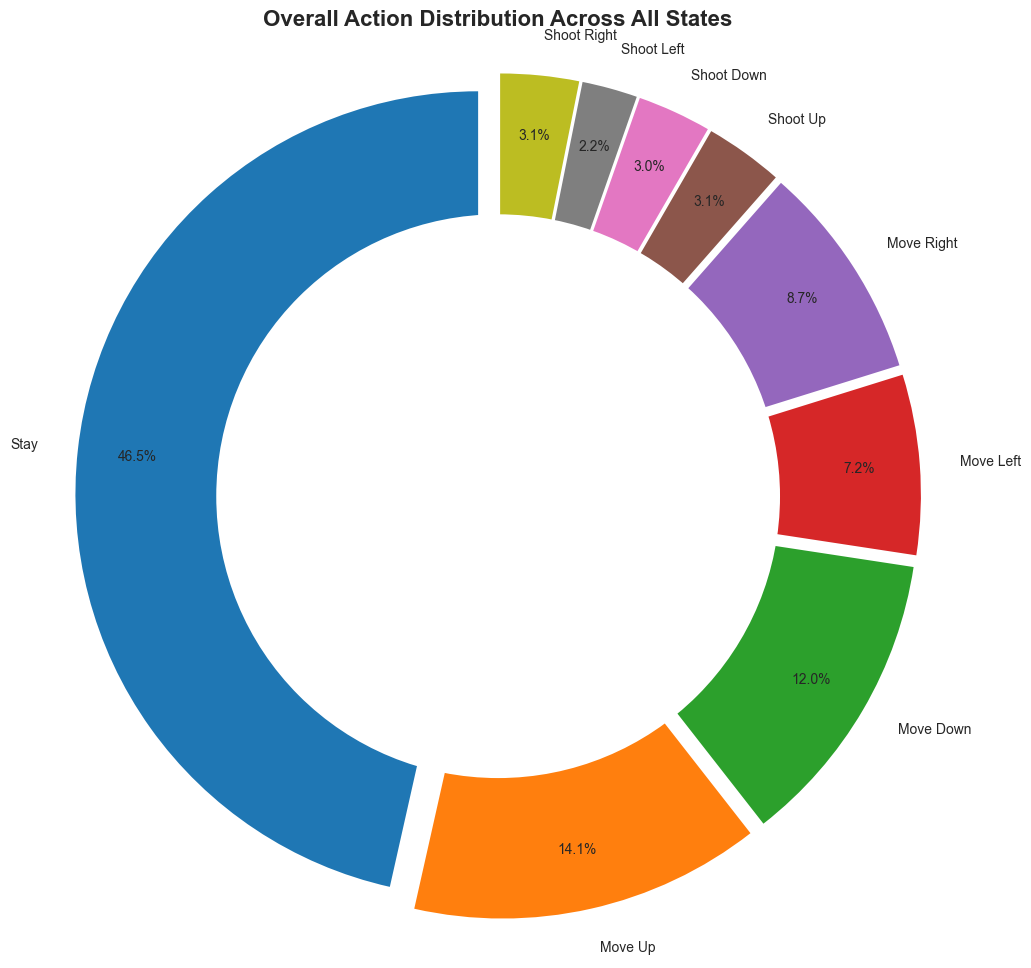

In [7]:
# Find the best action for every state
best_actions = np.argmax(q_table, axis=4).flatten()

# Count the occurrences of each action
action_counts = pd.Series(best_actions).value_counts().sort_index()

# Create the pie chart
fig, ax = plt.subplots(figsize=(12, 12))
ax.pie(action_counts, labels=[actions[i] for i in action_counts.index], autopct='%1.1f%%', 
       startangle=90, pctdistance=0.85, explode=[0.05]*len(action_counts)) # Explode slices slightly

# Draw a circle to make it a donut chart
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)

ax.set_title('Overall Action Distribution Across All States', fontsize=16, fontweight='bold')
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

#### Interpretation: A Defensive but Ready Agent

The donut chart reveals the agent's overall learned personality. The four **'Move'** actions collectively make up the largest portion of the pie. This is a strong indicator of a successful survival strategy. The agent has learned that repositioning and evasion are the most important actions in the majority of situations.

However, the four **'Shoot'** actions are also significantly represented, showing that the agent is not purely passive. It understands that it must attack to score points and clear threats. The **'Stay'** action is the least frequent, which is logical; in a game with constantly approaching enemies, standing still is rarely the optimal choice.

## 4. Overall Conclusion

The quantitative and qualitative analyses confirm the success of the Q-learning implementation. The learning curve demonstrates that the agent consistently improved its performance over time and eventually converged on a stable policy. The deep dive into the final Q-table reveals that this policy is not random but consists of a set of coherent and intelligent strategies for evasion, offense, and inaction based on the game state.

Crucially, the agent has learned nuanced behaviors, such as playing more cautiously when health is low or when its movement is constrained. This analysis validates that the agent has successfully learned to play "Zombie Shooter" effectively within the constraints of its defined state and action spaces.